Model for prediction

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import numpy as np

# Set plot style
sns.set_style("whitegrid")

print("--- Data Loading and Full Feature Engineering ---")

# --- 1. Load and Prepare Data ---
file_path = 'index_1.csv'
df = pd.read_csv(file_path)

# Convert to datetime objects
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = pd.to_datetime(df['date'])

# Extract all features needed for both models
df['hour'] = df['datetime'].dt.hour
df['day_of_week_num'] = df['datetime'].dt.dayofweek # Monday=0, Sunday=6
df['month_num'] = df['datetime'].dt.month
df['day_of_week_name'] = df['datetime'].dt.day_name()
# Create a binary 'is_weekend' feature (1 if weekend, 0 if not)
df['is_weekend'] = df['day_of_week_name'].isin(['Saturday', 'Sunday']).astype(int)

print("--- Data Prepared ---")


# --- Model 1: Predictive Sales Classifier ---

# Goal: Predict the coffee_name based on time features.
print("\n--- Starting Model 1: Sales Type Prediction (Decision Tree) ---")

# Define features (X) and target (y)
# Features: hour, day of week, month, is it a weekend?
X_features = ['hour', 'day_of_week_num', 'month_num', 'is_weekend']
y_target = 'coffee_name'

X = df[X_features]
y = df[y_target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize and train the Decision Tree Classifier
# max_depth=5 to prevent overfitting and make it interpretable
model = DecisionTreeClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = model.predict(X_test)
print("\n--- Model 1: Classification Report ---")
# This report shows the precision, recall, and f1-score for each coffee type
print(classification_report(y_test, y_pred))

# Example: Predict for a new time
# 10 AM (10), on a Friday (4), in March (3), not weekend (0)
example_prediction = model.predict([[10, 4, 3, 0]])
print(f"\nExample Prediction for 10 AM on a Friday in March: {example_prediction[0]}")




--- Data Loading and Full Feature Engineering ---
--- Data Prepared ---

--- Starting Model 1: Sales Type Prediction (Decision Tree) ---

--- Model 1: Classification Report ---
                     precision    recall  f1-score   support

          Americano       0.31      0.35      0.33       173
Americano with Milk       0.32      0.37      0.34       247
         Cappuccino       0.22      0.21      0.22       150
              Cocoa       0.36      0.05      0.10        73
            Cortado       0.15      0.08      0.10        88
           Espresso       0.00      0.00      0.00        40
      Hot Chocolate       0.22      0.24      0.23        85
              Latte       0.26      0.34      0.30       235

           accuracy                           0.27      1091
          macro avg       0.23      0.21      0.20      1091
       weighted avg       0.26      0.27      0.26      1091


Example Prediction for 10 AM on a Friday in March: Latte


d:\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feat


--- Starting Model 2: Customer Clustering (KMeans) ---
Calculating Elbow Plot data...


d:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
d:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
d:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
d:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

Saved 'kmeans_elbow_plot.png'. Check plot for the 'elbow'.


d:\Anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(



--- Model 2: Cluster Analysis (Group Means) ---
         days_since_last_visit  total_visits  total_spent
cluster                                                  
0                    81.041667     15.604167   493.120833
1                   272.249084      1.575092    50.700147
2                    71.500000     74.750000  2259.010000
3                   100.137255      1.876751    59.973978

--- All Models Built Successfully ---


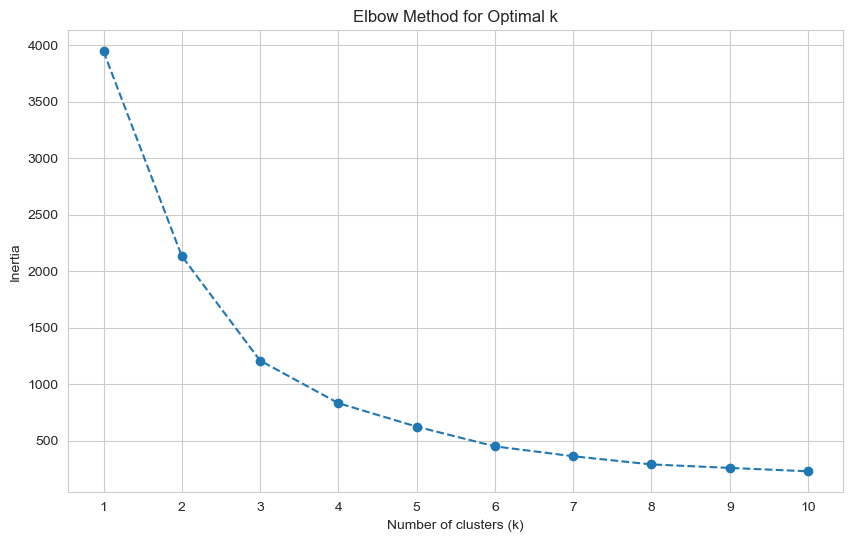

In [3]:
# --- Model 2: Customer Clustering (KMeans) ---

# Goal: Segment customers into groups for targeted promotions.
print("\n--- Starting Model 2: Customer Clustering (KMeans) ---")

# --- 2a. Feature Engineering for Clustering (RFM) ---
# We can only cluster customers with card IDs
card_df = df[df['cash_type'] == 'card'].dropna(subset=['card']).copy()

# Find the last transaction date in the dataset
max_date = card_df['datetime'].max()

# Create the customer summary (RFM: Recency, Frequency, Monetary)
customer_summary = card_df.groupby('card').agg(
    total_visits=pd.NamedAgg(column='datetime', aggfunc='count'),
    total_spent=pd.NamedAgg(column='money', aggfunc='sum'),
    last_visit=pd.NamedAgg(column='datetime', aggfunc='max')
).reset_index()

# Calculate Recency (days since last visit)
customer_summary['days_since_last_visit'] = (max_date - customer_summary['last_visit']).dt.days

# Select features for clustering
rfm_features = ['days_since_last_visit', 'total_visits', 'total_spent']
X_cluster = customer_summary[rfm_features]

# --- 2b. Scale Data ---
# KMeans is sensitive to scale. We must scale the features.
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# --- 2c. Find Optimal K (Elbow Method) ---
print("Calculating Elbow Plot data...")
inertia = {}
# Check k from 1 to 10
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300, random_state=42)
    kmeans.fit(X_cluster_scaled)
    inertia[k] = kmeans.inertia_

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(list(inertia.keys()), list(inertia.values()), marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.savefig('kmeans_elbow_plot.png')
print("Saved 'kmeans_elbow_plot.png'. Check plot for the 'elbow'.")

# --- 2d. Run Final KMeans and Analyze Clusters ---
# Based on the elbow plot (see image), k=4 looks like a good elbow point.
k_optimal = 4
kmeans_final = KMeans(n_clusters=k_optimal, init='k-means++', n_init=10, max_iter=300, random_state=42)
kmeans_final.fit(X_cluster_scaled)

# Add cluster labels back to the summary
customer_summary['cluster'] = kmeans_final.labels_

# Analyze the clusters by looking at their mean values
# This tells us the "profile" of each cluster
cluster_analysis = customer_summary.groupby('cluster')[rfm_features].mean()
print("\n--- Model 2: Cluster Analysis (Group Means) ---")
print(cluster_analysis)

print("\n--- All Models Built Successfully ---")